In [ ]:
from typing import Any, Dict

from graph.chains.retrieval_grader import retrieval_grader
from graph.state import GraphState

Q. why do you need grade document?<br>
A. So after we've implemented the retrieve node, we're going to implement now the document grader node. So when we enter this node we have retrieve documents in our state the. <br> 
So now we want to iterate over those documents and to determine whether they are indeed relevant to our question or not.<br>
if the document is not relevant, we want to filter it out and keep only the documents which are relevant to the question. And if not all documents are relevant. So this means that at least one document is not relevant to our query. Then we want to mark the web search flag to be true.<br>

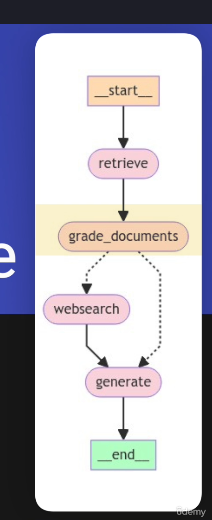

grade document node uses `answer_grade` chain:

```python

from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_core.runnables import RunnableSequence
from langchain_openai import ChatOpenAI

class GradeAnswer(BaseModel):

    binary_score: bool = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


llm = ChatOpenAI(temperature=0)
structured_llm_grader = llm.with_structured_output(GradeAnswer)

system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader: RunnableSequence = answer_prompt | structured_llm_grader
```

Q. what happens in `answer_grade` chain?


A. So for that we're going to be writing a retrieval grader chain, which is going to use structured output from our LM and turning it into a pedantic object (using `GradeAnswer` class) that will have the information, whether this document is relevant or not ('yes' or 'no'). <br> 

# grade_documents
define `grade_documents` node using `answer_grader` chain.

In [ ]:
def grade_documents(state: GraphState) -> Dict[str, Any]:
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    filtered_docs = []
    web_search = False
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            web_search = True
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}


Q. what happens in `grade_document` node?<br>

A. with grade_document node, if the document is not relevant, we want to filter it out and keep only the documents which are relevant to the question.<br>
And if not all documents are relevant. So this means that at least one document is not relevant to our query. Then we want to mark the web search flag to be true. So we'll go and later search for this term. And this is a simple heuristic we're making here.